In [2]:
import numpy as np
from matplotlib.pyplot import *
import h5py
sys.path.append('/home/fdfuller/work/analytic_von_hamos/') 
from analytic_von_hamos.raytracing import *
import gpflow
import tensorflow as tf
from analytic_von_hamos.data_extraction import get_peaks_and_intensity as pk
import tensorflow_probability as tfp
tfd = tfp.distributions
from IPython.display import Image, HTML, clear_output
tfb = tfp.bijectors
import imageio
import os
import pickle
%matplotlib inline

In [4]:
with h5py.File('../Data/ferro_cyanide_7195.h5','r') as fid:
    imgs = np.array(fid['imgs'])
img_ferro_cn6 = np.mean(imgs,axis=0)
img = img_ferro_cn6

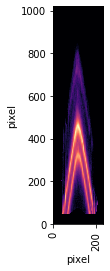

In [5]:
figure()
imshow(np.log(np.clip(img, a_min=0.1, a_max=20)),cmap='magma')
xlabel('pixel')
ylabel('pixel')
ax = gca()
ax.set_aspect(1.0)
xticks(rotation=90)
ax.invert_yaxis()
savefig('experimental_intensity.pdf')

In [6]:
p = pk.reduce_to_peaks_with_intensities(img, slice(80,800), slice(70,170), width=[25, 100])
p0,p2,p1 = pk.partition_peaks_with_intensities(p,3)
ka1_manifold = np.fliplr(p0[:2,:].T)
ka2_manifold = np.fliplr(p1[:2,:].T)
sat_manifold = np.fliplr(p2[:2,:].T)

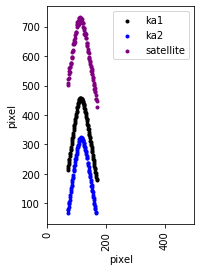

In [8]:
figure()
ax = subplot(111)

# ax.scatter(p[1,:], p[0,:],marker='+',color='black',label='all')
ax.scatter(ka1_manifold[:,0], ka1_manifold[:,1],marker='.',color='k',label='ka1')
ax.scatter(ka2_manifold[:,0], ka2_manifold[:,1],marker='.',color='b',label='ka2')
ax.scatter(sat_manifold[:,0], sat_manifold[:,1],marker='.',color='purple',label='satellite')
legend()
ax.set_aspect(1.0)
xticks(rotation=90)
xlim([0,500])
xlabel('pixel')
ylabel('pixel')
savefig('peak_reduced_data.pdf')

In [9]:
def change_of_basis(t,u,v):
    if t.ndim == 1:
        t = t[:,None]
    if u.ndim == 1:
        u = u[:,None]
    if v.ndim == 1:
        v = v[:,None]
    tuv = np.concatenate([np.atleast_2d(t),np.atleast_2d(u),np.atleast_2d(v)],-1)
    row_1 = tuv
    row_2 = -np.cross(tuv,np.cross((1,0,0), (0,1,0))[None,:])
    row_3 = np.cross(tuv, np.array((0,1,0))[None,:])
    T = np.concatenate([row_1[:,None,:], row_2[:,None,:], row_3[:,None,:]],1)
    return np.linalg.inv(T)

def initial_guesses_for_experimental_geometry(N: int):
    grand = lambda x0, xu: np.random.uniform(low=x0-xu/2, high=x0+xu/2, size=(N,))
    f = 125
#     c0 = 39.36
    c0 = 39
    a0 = 151.21
    b0 = 0.
    d0 = (5/4)*f
    d_uncertainty = 15
    a_uncertainty = 15
    b_uncertainty = 15
    c_uncertainty = 15
    
    
    def ac_from_dc():
        d = grand(d0,d_uncertainty)
        c = grand(c0,c_uncertainty)
        return np.sqrt(d**2 - c**2), c
    a,c = ac_from_dc()
    b = grand(b0,b_uncertainty)
    
    p0 = 352.1
    q0 = 0.0
#     r0 = 157.46+60
    r0 = 157.46+59
    q_uncertainty = 10
    r_uncertainty = 10
    
    dd0 = 700
    dd_uncertainty = 30
    p_uncertainty = 20
    
    def pr_from_ddr():
        dd = grand(dd0,dd_uncertainty)
        r = grand(r0,r_uncertainty)
        return np.sqrt(dd**2 - r**2), r
    
    p, r = pr_from_ddr()
    q = grand(q0, q_uncertainty)
    
    t0 = 1
    u0 = 0
    v0 = 0
    t_uncertainty = 0.005
    u_uncertainty = 0.005
    v_uncertainty = 0.005
    
    t = grand(t0,t_uncertainty)
    u = grand(u0,u_uncertainty)
    v = grand(v0,v_uncertainty)
    T = change_of_basis(t,u,v)
    
    pqr = np.concatenate([p[:,None],q[:,None],r[:,None]],-1)
    pqr_prime = np.einsum('ijk,ik->ij',T,pqr)
    
    pp = pqr_prime[:,0]
    qp = pqr_prime[:,1]
    rp = pqr_prime[:,2]
    return {'a': a, 'b': b, 'c': c, 'p': p, 'q': q, 'r': r, 't': t, 'u': u, 'v': v}
    

In [17]:
# handtuned_init = {
#     'energy1': 6405.84, #eV (near Fe K alpha energy),
#     'energy2': 6392.1+0.75, #eV (near Fe K alpha energy),
#     "a0": 156.0 ,
#     "b0": -0.04 ,
#     "c0": 20.0 ,
#     "p0": 661.0 ,
#     "q0": -6.0 ,
#     "r0": 210.0 ,
#     "t0": 4.501 ,
#     "u0": 0.0 ,
#     "v0": 0.0 ,
# }

In [ ]:
initial_guess = initial_guesses_for_experimental_geometry(250)
m = TwoLineFit(ka1_manifold, ka2_manifold, **{**initial_guesses_for_experimental_geometry(250),
                                              'radius': 250,
                                              'energy1': 6402.468117602138,
                                              'energy2': 6389.69033982436,
                                              'theta_max': np.pi/5,
                                              'theta_min': -np.pi/5,
                                              'xtal': CrystalGe(4,4,0)
                                             })


opt_i0 = tf.argmin(m._individual_training_losses())
opt_loss0 = m._individual_training_losses()[opt_i0]
p0 = m.get_params(opt_i0)
print('initial best guess loss: ', opt_loss0)

def plot_loss(loss_log, best_loss_log):
    figure(figsize=(10, 4))
    title('Loss history')
    semilogy(loss_log, 'k-.',alpha=0.3)
    figure(figsize=(10, 4))
    title('Best Loss history')
    semilogy(best_loss_log, 'r-.',alpha=0.9)
    show()
    
lr = 1E-2
# lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
#     [1000, 2000, 3000, 4000, 5000], [lr, lr*0.5, lr*(0.5**2), lr*(0.5**3), lr*(0.5**4), lr*(0.5**5)])
lr_sched = tf.keras.experimental.CosineDecayRestarts(lr, 1000, alpha=0.1, m_mul=0.9, t_mul=1.0)
trainer = tf.keras.optimizers.Adam(lr_sched)

@tf.function
def train_step():
    with tf.GradientTape() as g:
        loss = m.training_loss()
    grads = g.gradient(loss, m.trainable_variables)
#     grads = [g/(tf.norm(g)+1e-8) for g in grads]
    trainer.apply_gradients(zip(grads, m.trainable_variables))
    return loss

loss_log = []
best_loss_log = []
prediction_log = []
M = 100
for i in range(16000):
    loss = train_step()
    loss_log.append(loss.numpy())
    step_i = len(loss_log)
    if step_i%10 == 0:
        prediction_log.append(m.raytracing_slice(m.energy1, 20))
    if step_i%100 == 0:
        clear_output()
        indiv_losses = m._individual_training_losses()
        best_loss_ind = tf.argmin(indiv_losses)
        best_loss_log.append(indiv_losses[best_loss_ind].numpy().item())
        plot_loss(loss_log, best_loss_log)
    if step_i%150 == 0:
        # prune the bad ones
        s = tf.argsort(m._individual_training_losses()).numpy()
        # replace bad ones with scrambled versions of the top 20 particles
        ap = np.concatenate([m.a.numpy()[s[:-M]], m.a.numpy()[s[np.random.choice(M,M)]]],0)
        bp = np.concatenate([m.b.numpy()[s[:-M]], m.b.numpy()[s[np.random.choice(M,M)]]],0)
        cp = np.concatenate([m.c.numpy()[s[:-M]], m.c.numpy()[s[np.random.choice(M,M)]]],0)
        pp = np.concatenate([m.p.numpy()[s[:-M]], m.p.numpy()[s[np.random.choice(M,M)]]],0)
        qp = np.concatenate([m.q.numpy()[s[:-M]], m.q.numpy()[s[np.random.choice(M,M)]]],0)
        rp = np.concatenate([m.r.numpy()[s[:-M]], m.r.numpy()[s[np.random.choice(M,M)]]],0)
        tp = np.concatenate([m.t.numpy()[s[:-M]], m.t.numpy()[s[np.random.choice(M,M)]]],0)
        up = np.concatenate([m.u.numpy()[s[:-M]], m.u.numpy()[s[np.random.choice(M,M)]]],0)
        vp = np.concatenate([m.v.numpy()[s[:-M]], m.v.numpy()[s[np.random.choice(M,M)]]],0)
        m.a.assign(ap)
        m.b.assign(bp)
        m.c.assign(cp)
        m.p.assign(pp)
        m.q.assign(qp)
        m.r.assign(rp)
        m.t.assign(tp)
        m.u.assign(up)
        m.v.assign(vp)
    print('\r step: %d, loss: %.3f'%(len(loss_log), loss), end='')

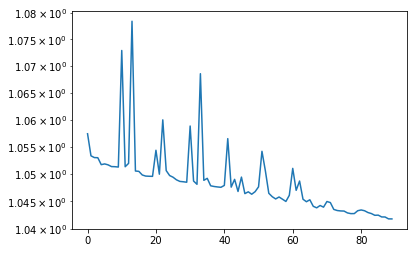

In [16]:
figure()
semilogy(best_loss_log[50:])

In [9]:
opt_i = tf.argmin(m._individual_training_losses())

In [10]:
m._individual_training_losses()[opt_i]

<tf.Tensor: shape=(), dtype=float64, numpy=1.0496737990022877>

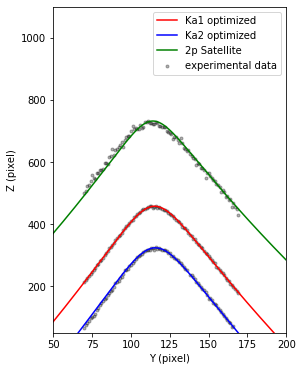

In [47]:
figure(figsize=(6,6))
k = 147
fit_line1 = m.raytracing_pts(6402.468117602138)*m.mm_to_pixels
fit_line2 = m.raytracing_pts(6389.69033982436)*m.mm_to_pixels
fit_line3 = m.raytracing_pts(6430)*m.mm_to_pixels
plot(fit_line1[opt_i,:,0].numpy().T,fit_line1[opt_i,:,1].numpy().T,'r',label='Ka1 optimized');
plot(fit_line2[opt_i,:,0].numpy().T,fit_line2[opt_i,:,1].numpy().T,'b',label='Ka2 optimized');
plot(fit_line3[opt_i,:,0].numpy().T,fit_line3[opt_i,:,1].numpy().T,'g',label='2p Satellite');
scatter(ka1_manifold[:,0],ka1_manifold[:,1],marker='.',c='k',alpha=0.3, label='experimental data')
scatter(ka2_manifold[:,0],ka2_manifold[:,1],marker='.',c='k',alpha=0.3)
scatter(sat_manifold[:,0],sat_manifold[:,1],marker='.',c='k',alpha=0.3)
xlabel('Y (pixel)')
ylabel('Z (pixel)')
ax = gca()
ax.set_aspect(0.2)
legend(loc=0)
xlim([50,200])
ylim([50,1100])
savefig('optimized_fit_to_exp.pdf')

In [20]:
import imageio
import os

In [48]:
preds = tf.stack([p[:,:540,:] for p in prediction_log],0)
filenames = []
figure()
for k in range(len(prediction_log)):
    plot(preds[k,0,:,0]*20,preds[k,0,:,1]*20,'r-')
    scatter(ka1_manifold[:,0],ka1_manifold[:,1],marker='.')
    plot(preds[k,1,:,0]*20,preds[k,1,:,1]*20,'k-', alpha=0.1)
    plot(preds[k,2,:,0]*20,preds[k,2,:,1]*20,'k-', alpha=0.1)
    plot(preds[k,3,:,0]*20,preds[k,3,:,1]*20,'k-', alpha=0.1)
    plot(preds[k,4,:,0]*20,preds[k,4,:,1]*20,'k-', alpha=0.1)
    plot(preds[k,5,:,0]*20,preds[k,5,:,1]*20,'k-', alpha=0.1)
    plot(preds[k,6,:,0]*20,preds[k,6,:,1]*20,'k-', alpha=0.1)
    plot(preds[k,7,:,0]*20,preds[k,7,:,1]*20,'k-', alpha=0.1)
    plot(preds[k,8,:,0]*20,preds[k,8,:,1]*20,'k-', alpha=0.05)
    plot(preds[k,9,:,0]*20,preds[k,9,:,1]*20,'k-', alpha=0.05)
    plot(preds[k,10,:,0]*20,preds[k,10,:,1]*20,'k-', alpha=0.05)
    plot(preds[k,11,:,0]*20,preds[k,11,:,1]*20,'k-', alpha=0.05)
    plot(preds[k,12,:,0]*20,preds[k,12,:,1]*20,'k-', alpha=0.05)
    plot(preds[k,13,:,0]*20,preds[k,13,:,1]*20,'k-', alpha=0.05)
    plot(preds[k,14,:,0]*20,preds[k,14,:,1]*20,'k-', alpha=0.01)
    plot(preds[k,15,:,0]*20,preds[k,15,:,1]*20,'k-', alpha=0.01)
    plot(preds[k,16,:,0]*20,preds[k,16,:,1]*20,'k-', alpha=0.01)
    plot(preds[k,17,:,0]*20,preds[k,17,:,1]*20,'k-', alpha=0.01)
    plot(preds[k,18,:,0]*20,preds[k,18,:,1]*20,'k-', alpha=0.01)
    plot(preds[k,19,:,0]*20,preds[k,19,:,1]*20,'k-', alpha=0.01)
    xlim([50,250])
    ylim([50,550])
    ax = gca()
    ax.set_aspect(3/4)
    xlabel('Y (pixel)')
    ylabel('Z (pixel)')
    
    # create file name and append it to a list
    filename = f'{k}.png'
    filenames.append(filename)
    
    # save frame
    savefig(filename)
    close()# build gif

In [49]:
with imageio.get_writer('optimization_experimental4.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)

In [50]:
m.get_params(opt_i)

({'a': 155.35938647157317,
  'b': -2.190018653810878,
  'c': 32.29479458474249,
  'p': 669.8893432529293,
  'q': 3.986599133053362,
  'r': 222.21858762191354,
  't': 1.6395859626238676,
  'u': -0.3025341581582192,
  'v': 0.27823045148882775,
  'energy': <tf.Tensor: shape=(), dtype=float64, numpy=6402.468117602138>,
  'radius': 250,
  'theta_min': -0.6283185307179586,
  'theta_max': 0.6283185307179586,
  'mm_to_pixels': 20},
 {'a': 155.35938647157317,
  'b': -2.190018653810878,
  'c': 32.29479458474249,
  'p': 669.8893432529293,
  'q': 3.986599133053362,
  'r': 222.21858762191354,
  't': 1.6395859626238676,
  'u': -0.3025341581582192,
  'v': 0.27823045148882775,
  'energy': <tf.Tensor: shape=(), dtype=float64, numpy=6389.69033982436>,
  'radius': 250,
  'theta_min': -0.6283185307179586,
  'theta_max': 0.6283185307179586,
  'mm_to_pixels': 20})